<a href="https://colab.research.google.com/github/SilverSurferClash/Sales_analysis/blob/main/Import_clean_SFDC_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1419]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1420]:
#!pip freeze > requirements.txt

In [1421]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('dark_background')
import seaborn as sns
import os
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)
#Use option to round floats to two decimals
#pd.set_option('display.float_format',  '{:,.2f}'.format)
# Use option to display $ dollars
#pd.set_option('display.float_format', '${:.2f}'.format)
#sns.set_style("whitegrid")
# Plotting pretty figures and avoid blurry images
#%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
#sns.set_context('notebook')


# Enable multiple cell outputs
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')              


In [1422]:
os.getcwd()

'/content/drive/My Drive/Colab_Notebooks/November_2022'

In [1423]:
os.chdir("/content/drive/MyDrive/Colab_Notebooks/November_2022")

#### Helper function

In [1424]:
#Create a function that use the second element if the list has a length of 2 other return unknown

def clean_up_account(list_of_names):

  if len(list_of_names) == 2:
    return list_of_names[1]
  else:
    return list_of_names[0]





In [1425]:
#Create a function to clean up the Billing type feature


Import helper data

In [1426]:
#Import lookup table for countries
lookup_countries = pd.read_excel("./lookup.xlsx", sheet_name = 0)
#Import the data from SFDC as a excel file
import_sfdc = pd.read_excel("./Prospective.xlsx", sheet_name = 0, 
                            skiprows = 10)
#Create dictionairy for maping the lookup value
country_dict = dict(zip(lookup_countries["Reporting_Country_short"], lookup_countries["Account_Reporting_Country"]))
#Import lookup table for countries
lookup_type = pd.read_excel("./lookup.xlsx", sheet_name = "Type")
#Create dictionairy for maping the lookup values for LIMS ID
type_dict = dict(zip(lookup_type["LIMS Project ID"], lookup_type["Type"]))
#Dictionaire for AE support countries 
AE_dict = { 'CANADA': "AE", "SPAIN" : "AE", "UNITED KINGDOM" : "AE", "BRAZIL" : "AE", "TURKEY" : "AE", "IRELAND" : "AE"}
#Import lookup Cancer Type
lookup_cancer_type = pd.read_excel("./lookup.xlsx", sheet_name = "Cancer_type")
cancer_type_dict = dict(zip(lookup_cancer_type["Old"], lookup_cancer_type["New"]))
#Map the countries to the sub-regions
subregion_dict = dict(zip(lookup_countries["Account_Reporting_Country"], lookup_countries["Sub_region"]))
#Import the currency data
lookup_currency = pd.read_excel("./lookup.xlsx", sheet_name = "Currency", parse_dates= ["Month"]).set_index("Month")
lookup_currency["EUR"] = lookup_currency["EUR"]/1000000
lookup_currency["GBP"] = lookup_currency["GBP"]/1000000
lookup_currency["USD"] = 1

#Import the currency type
lookup_currency_type =  pd.read_excel("./lookup.xlsx", sheet_name = "curr_look")
#Inport lookun Billing_type - Needs further work
#lookup_billing_type = pd.read_excel("./lookup.xlsx", sheet_name = "Billing_type")
#billing_type_dict = dict(zip(lookup_billing_type["Billing Type"], lookup_billing_type["Billing Type.1"]))


In [1427]:
curr_dict = dict(zip(lookup_currency_type["Account_Reporting_Country"], lookup_currency_type["Currency"]))


curr_dict

{'CANADA': 'USD',
 'SPAIN': 'EUR',
 'ITALY': 'EUR',
 'URUGUAY': 'USD',
 'BRAZIL': 'USD',
 'ARGENTINA': 'USD',
 'HUNGARY': 'EUR',
 'UNITED KINGDOM': 'GBP',
 'MEXICO': 'EUR',
 'BELGIUM': 'EUR',
 'TURKEY': 'USD',
 'COLOMBIA': 'USD',
 'PERU': 'USD',
 'FRANCE': 'EUR',
 'GERMANY': 'EUR',
 'PORTUGAL': 'EUR',
 'SWITZERLAND': 'EUR',
 'COSTA RICA': 'USD',
 'CHILE': 'USD',
 'SWEDEN': 'EUR',
 'NETHERLANDS': 'EUR',
 'DENMARK': 'EUR',
 'IRELAND': 'EUR',
 'GREECE': 'EUR',
 'AUSTRIA': 'EUR',
 'CZECH REPUBLIC': 'EUR',
 'CROATIA': 'EUR',
 'UKRAINE': 'EUR',
 'SLOVENIA': 'EUR',
 'RUSSIA': 'USD',
 'BELARUS': 'USD',
 'FINLAND': 'EUR',
 'PUERTO RICO': 'USD',
 'LITHUANIA': 'EUR',
 'NORTH MACEDONIA': 'EUR',
 'ROMANIA': 'EUR',
 'LUXEMBOURG': 'EUR',
 'POLAND': 'EUR'}

In [1428]:

print(f"the currenvy rate is {lookup_currency.iloc[1,0]}")
lookup_currency.head(3)

the currenvy rate is 1.123847


,EUR,GBP,old,Unnamed: 4,USD
Month,,,,,
2015-08-01,1.11,1.56,2022-08-15,NaN,1
2015-09-01,1.12,1.53,2022-09-15,NaN,1
2015-10-01,1.12,1.53,2022-10-15,NaN,1


In [1429]:
import_sfdc.head()

,Unnamed: 0,Accession #,Unnamed: 2,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Date Received,Final Report Date,Test Type,Cancer Type
0,NaN,A0214386,NaN,CH,Pharma : ROW,AMG_01,AMG_01: Universitatsspital Zurich,Alessandra Curioni Fontecedro,11/25/2019,NaN,Guardant 360,Lung adenocarcinoma
1,NaN,A0214865,NaN,CA,Pharma : ROW,AMG_01,AMG_01: Princess Margaret Cancer Centre,Adrian Sacher,11/26/2019,NaN,Guardant 360,Lung adenocarcinoma
2,NaN,A0215878,NaN,BE,Pharma : ROW,AMG_01,AMG_01: Universitair Ziekenhuis Antwerpen,Hans Prenen,11/29/2019,NaN,Guardant 360,Lung adenocarcinoma
3,NaN,A0215958,NaN,DE,Pharma : US,AMG_01,AMG_01: Universitatsklinikum Koln,Wolf Juergen,11/30/2019,NaN,Guardant 360,Lung adenocarcinoma
4,NaN,A0215959,NaN,DE,Pharma : ROW,AMG_01,AMG_01: Universitatsklinikum Koln,Wolf Juergen,11/30/2019,NaN,Guardant 360,Lung adenocarcinoma


In [1430]:
#Identify which LIMS id are not in the lookup
unique_LIMS_id = list(set(import_sfdc["LIMS Project ID"]))
unique_lookup_id = list(set(lookup_type["LIMS Project ID"]))
list(set(unique_LIMS_id) - set(unique_lookup_id ))

[nan,
 'RHI_04',
 'OCT_1R',
 'TRM_01',
 'GAP_09',
 'GAP_04',
 'JNS_01',
 'AZN_test_96',
 'JNJ_32_EU']

In [1431]:
import_sfdc.head()

,Unnamed: 0,Accession #,Unnamed: 2,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Date Received,Final Report Date,Test Type,Cancer Type
0,NaN,A0214386,NaN,CH,Pharma : ROW,AMG_01,AMG_01: Universitatsspital Zurich,Alessandra Curioni Fontecedro,11/25/2019,NaN,Guardant 360,Lung adenocarcinoma
1,NaN,A0214865,NaN,CA,Pharma : ROW,AMG_01,AMG_01: Princess Margaret Cancer Centre,Adrian Sacher,11/26/2019,NaN,Guardant 360,Lung adenocarcinoma
2,NaN,A0215878,NaN,BE,Pharma : ROW,AMG_01,AMG_01: Universitair Ziekenhuis Antwerpen,Hans Prenen,11/29/2019,NaN,Guardant 360,Lung adenocarcinoma
3,NaN,A0215958,NaN,DE,Pharma : US,AMG_01,AMG_01: Universitatsklinikum Koln,Wolf Juergen,11/30/2019,NaN,Guardant 360,Lung adenocarcinoma
4,NaN,A0215959,NaN,DE,Pharma : ROW,AMG_01,AMG_01: Universitatsklinikum Koln,Wolf Juergen,11/30/2019,NaN,Guardant 360,Lung adenocarcinoma


#### Import and clean up the data from SFDC

In [1432]:
#Remove the first two columns
import_sfdc = import_sfdc.drop(["Unnamed: 0", "Unnamed: 2"], axis = 1)
#Drop the last five rows
import_sfdc = import_sfdc.iloc[0:-5]
#Cast Date Received to datetime object 
#import_sfdc["Date Received"] = pd.to_datetime(import_sfdc["Date Received"])
#Clean up the type column
import_sfdc["Type"] = import_sfdc["LIMS Project ID"].map(type_dict)

#Replace the two letter country code with the full country name
import_sfdc["Reporting Country"] = import_sfdc["Reporting Country"].map(country_dict)
#Clean up the cancer types and reduce number of categories
import_sfdc["Cancer Type"] = import_sfdc["Cancer Type"].map(cancer_type_dict)
#Clean up the Account column by removing all strings before the ":"
import_sfdc["Account: Account Name"] = import_sfdc.loc[:, "Account: Account Name"].str.split(":").apply(clean_up_account)

#Clean up the Billing type column 
#import_sfdc["Billing Type"] = import_sfdc["Billing Type"].map(billing_type_dict)
#import_sfdc.tail(6)

# Set the date recieved as date index
#import_sfdc = import_sfdc.set_index("Date Received")

#import_sfdc.info()

In [1433]:
#df[“column_name”] = np.where(df[“column_name”]==”some_value”, value_if_true, value_if_false)
import_sfdc["AE_supported"] = np.where(import_sfdc["Reporting Country"].isin(AE_dict.keys()), "AE", "non_AE")

#Add a column with the information about the currency based on the imported dictionairy
import_sfdc["Currency"] = import_sfdc["Reporting Country"].map(curr_dict)


In [1434]:
import_sfdc

,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Date Received,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency
0,A0214386,SWITZERLAND,Pharma : ROW,AMG_01,Universitatsspital Zurich,Alessandra Curioni Fontecedro,11/25/2019,NaN,Guardant 360,NaN,Biopharma,non_AE,EUR
1,A0214865,CANADA,Pharma : ROW,AMG_01,Princess Margaret Cancer Centre,Adrian Sacher,11/26/2019,NaN,Guardant 360,NaN,Biopharma,AE,USD
2,A0215878,BELGIUM,Pharma : ROW,AMG_01,Universitair Ziekenhuis Antwerpen,Hans Prenen,11/29/2019,NaN,Guardant 360,NaN,Biopharma,non_AE,EUR
3,A0215958,GERMANY,Pharma : US,AMG_01,Universitatsklinikum Koln,Wolf Juergen,11/30/2019,NaN,Guardant 360,NaN,Biopharma,non_AE,EUR
4,A0215959,GERMANY,Pharma : ROW,AMG_01,Universitatsklinikum Koln,Wolf Juergen,11/30/2019,NaN,Guardant 360,NaN,Biopharma,non_AE,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15746,A0318002,UNITED KINGDOM,Research : ROW,VLT_01,VLT_01-Royal Brompton Hospital,RS-Eric Lim,1/6/2021,NaN,LUNAR1_3,NaN,Lunar,AE,GBP
15747,A0319936,UNITED KINGDOM,Research : ROW,VLT_01,VLT_01-Royal Brompton Hospital,RS-Eric Lim,1/11/2021,NaN,LUNAR1_3,NaN,Lunar,AE,GBP
15748,A0319935,UNITED KINGDOM,Research : ROW,VLT_01,VLT_01-Royal Brompton Hospital,RS-Eric Lim,1/11/2021,NaN,LUNAR1_3,NaN,Lunar,AE,GBP
15749,A0320961,UNITED KINGDOM,Research : ROW,VLT_01,VLT_01-Royal Brompton Hospital,RS-Eric Lim,1/15/2021,NaN,LUNAR1_3,NaN,Lunar,AE,GBP


In [1435]:
import_sfdc["Sub_region"] = import_sfdc["Reporting Country"]
import_sfdc["Sub_region"] = import_sfdc["Sub_region"].map(subregion_dict)

In [1436]:
import_sfdc["Date Received"] = pd.to_datetime(import_sfdc["Date Received"])
import_sfdc = import_sfdc.set_index("Date Received")

In [1437]:
#Create date and time features

#Create a year, month, quarter variable
import_sfdc["Month"] = import_sfdc.index.month
import_sfdc["Year"] = import_sfdc.index.year
import_sfdc['Quarter'] = import_sfdc.index.quarter
#Other feature engineering based on feature analysis below
import_sfdc['Sales'] = 1

#create a Year Month columns
import_sfdc['Year_Month'] = import_sfdc.index.to_period('M')
#Cast the Year_Month column to a str
import_sfdc['Year_Month'] = import_sfdc['Year_Month'].astype(str)
import_sfdc['Year_Month'] = pd.to_datetime(import_sfdc['Year_Month'])
#Cast some features to categorical
#df['Reporting_Country'] = df['Reporting_Country'].astype('category')
import_sfdc['Type'] = import_sfdc['Type'].astype('category')
#Add a column to allow merging this datafarme with the currency_lookup
#import_sfdc["Month_to_match"] = f"{import_sfdc[["Year"]]}_{import_sfdc[["Month"]]}"
import_sfdc["Month_to_match"] = import_sfdc["Year"].astype("string") + "-" + import_sfdc["Month"].astype("string")

In [1438]:
import_sfdc["Year"]

Date Received
2019-11-25    2019
2019-11-26    2019
2019-11-29    2019
2019-11-30    2019
2019-11-30    2019
              ... 
2021-01-06    2021
2021-01-11    2021
2021-01-11    2021
2021-01-15    2021
2021-01-20    2021
Name: Year, Length: 15751, dtype: int64

In [1439]:
import_sfdc.sample(5)

,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Year_Month,Month_to_match
Date Received,,,,,,,,,,,,,,,,,,,
2021-12-15,A0444526,SPAIN,Pharma : ROW,JNJ_18_IUO,Hosp. Univ. Vall D'Hebron,Enriqueta Felip,12/22/2021,Guardant 360,NaN,Biopharma,AE,EUR,Europe,12,2021,4,1,2021-12-01,2021-12
2022-05-17,A0515266,ITALY,Do Not Bill - LUNAR,PGS_01,Istituto Oncologico Veneto IRCCS,Sara Lonardi,5/26/2022,LUNAR1_CRC,NaN,Lunar,non_AE,EUR,Europe,5,2022,2,1,2022-05-01,2022-5
2022-02-10,A0466273,SPAIN,Self-Pay Sponsored,GHI_01,Hospital del Mar,Laura Visa,2/16/2022,Guardant 360,NaN,Commercial,AE,EUR,Europe,2,2022,1,1,2022-02-01,2022-2
2019-12-12,A0219797,ARGENTINA,Pharma : ROW,PFE_14,Sanatorio de la Mujer,Cristina Nasurdi,12/19/2019,Guardant 360,Breast,Biopharma,non_AE,USD,Americas,12,2019,4,1,2019-12-01,2019-12
2021-05-26,A0358875,SPAIN,Pharma : US,GAP_05,Hospital Clinic de Barcelona - G360 Research,Javier Garcia-Corbacho,5/30/2021,Guardant 360,Breast,GAP,AE,EUR,Europe,5,2021,2,1,2021-05-01,2021-5


#### Explore the data

In [1440]:
#import_sfdc["Reporting Country"].value_counts()

In [1441]:
#import_sfdc.Type.value_counts()

In [1442]:
#import_sfdc.info()

In [1443]:
#import_sfdc["Billing Type"].value_counts()

In [1444]:
#import_sfdc["Test Type"].value_counts()

In [1445]:
#import_sfdc["Cancer Type"].value_counts()

In [1446]:
#import_sfdc['Billing Type'].value_counts()

In [1447]:
os.getcwd()

'/content/drive/MyDrive/Colab_Notebooks/November_2022'

In [1448]:
# Import the revenue data

revenue_import = pd.read_excel("./Sales_Volume_EUAA_Analytics_Oct_22.xlsx", skiprows = 28)
revenue_import = revenue_import.iloc[:, 1:12]
#revenue_import.columns.tolist()
revenue_import['Accession #']= revenue_import['Accession #'].fillna("missing") 
revenue_import = revenue_import[revenue_import['Accession #'].str.startswith("A0")]
#revenue_import.info()

In [1449]:
revenue_import.head()


,Account: Reporting Country ↑,Date Received,Accession #,Account: Account Name,Contact: Full Name,Billing Type,Final Report Date,Invoiced Amount,Expected Amount $,Invoiced/In Prg.,FOC
0,BR,9/30/2019,A0198807,Rede D'Or Hospital,Maria Ignez Braghiroli,Self-Pay Patient,10/6/2019,0.0,0.0,NaN,x
1,NaN,9/18/2019,A0196311,Rede D'Or Hospital,Milena Mak,Self-Pay Patient,9/26/2019,0.0,0.0,NaN,x
3,CA,9/17/2019,A0196102,Medicor Cancer Centres,Akbar Khan,Self-Pay Patient,9/26/2019,3490.0,3490.0,NaN,NaN
4,NaN,9/12/2019,A0195058,South Sherbrook Health Centre,Anthony Morham,Self-Pay Patient,9/20/2019,3490.0,3490.0,NaN,NaN
6,CL,9/18/2019,A0196290,Clinica Las Condes,Jose Miguel Reyes,Self-Pay Patient,9/26/2019,3490.0,3490.0,NaN,NaN


In [1450]:
#revenue_import.columns.tolist()

In [1451]:
revenue_col_list = ['Accession #', 'Invoiced Amount','Expected Amount $','Invoiced/In Prg.', 'FOC']

In [1452]:
#Define the clean up function for the FOC columns
def foc_clean_up(value):

  if value == "x":
    return "Free"

  elif value == "x (COV19)":
     return "Free"
  elif value == "x (Christie)":
    return "Free"
  else: 
    return value

#Clean up Docuten

def docuten_clean_up(value):

  if value == "y (DOCUTEN)":
    return "Free"

  else: 
    return value

#Clean up the revenue data and extract the free of charge information
revenue_import_clean = revenue_import.loc[:, revenue_col_list].copy()
revenue_import_clean["FOC"] = revenue_import_clean["FOC"].fillna("Paid")
revenue_import_clean.tail()

,Accession #,Invoiced Amount,Expected Amount $,Invoiced/In Prg.,FOC
4279,A0608339,1890.0,Accounts Receivable,NaN,Paid
4280,A0608344,0.0,G360 Experience Project 11/15,NaN,Paid
4281,A0606576,0.0,G360 Experience Project 13/15,NaN,Paid
4282,A0606586,2319.0,Accounts Receivable - G360 - 83 GENE,NaN,Paid
4283,A0605814,1890.0,Accounts Receivable - Tested as 2.12 by mistak...,NaN,Paid


In [1453]:
#revenue_import_clean["FOC"].value_counts()

In [1454]:
revenue_import_clean["FOC"] = revenue_import_clean["FOC"].apply(foc_clean_up).astype("category")

In [1455]:
revenue_import_clean["FOC"].value_counts()

Paid    3016
Free     736
           1
Name: FOC, dtype: int64

In [1456]:
#Join the two dataframes

df_merged = import_sfdc.merge(revenue_import_clean[["Accession #", "FOC", "Invoiced Amount"]], how='inner', on = "Accession #")
df_merged.sample(3)

,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Year_Month,Month_to_match,FOC,Invoiced Amount
1297,A0333865,BRAZIL,Distributors : ROW,GHI_01,Diagnosticos da America S.A.,Cristovam Scapulatempo Neto,3/10/2021,Guardant 360,NaN,Commercial,AE,USD,Americas,3,2021,1,1,2021-03-01,2021-3,Paid,1350.0
3692,A0603794,UNITED KINGDOM,Distributors : ROW,GHI_19,HCA Laboratories,Constantine Alifrangis,11/9/2022,Guardant360 CDx EU,NaN,Commercial,AE,GBP,Europe,10,2022,4,1,2022-10-01,2022-10,Paid,2178.75
12,A0533398,GERMANY,Self-Pay Patient,GH2_12,SLK Kliniken GMBH,Uwe Martens,6/29/2022,Guardant 360,NaN,Commercial,non_AE,EUR,Europe,6,2022,2,1,2022-06-01,2022-6,Paid,2990 EUR


In [1457]:
# Startinf dataframe for all years
#import_sfdc.info()

In [1458]:
#Cleaned up dataframe included FOC information starting from around 2019
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Accession #            3749 non-null   object        
 1   Reporting Country      3749 non-null   object        
 2   Billing Type           3749 non-null   object        
 3   LIMS Project ID        3749 non-null   object        
 4   Account: Account Name  3749 non-null   object        
 5   Contact: Full Name     3749 non-null   object        
 6   Final Report Date      3715 non-null   object        
 7   Test Type              3749 non-null   object        
 8   Cancer Type            1256 non-null   object        
 9   Type                   3749 non-null   category      
 10  AE_supported           3749 non-null   object        
 11  Currency               3749 non-null   object        
 12  Sub_region             3749 non-null   object        
 13  Mon

#### Plotting

In [1459]:
#Select the features for the analysis
import_sfdc.columns.to_list()
list_for_country_analysis = ['Accession #',
 'Reporting Country',
 'Type',
 'Sales',
 'Year_Month', "Sub_region", "AE_supported", "Currency"]

countries_df = import_sfdc.loc[:,list_for_country_analysis ]
#countries_df["Reporting Country"] = countries_df["Reporting Country"].astype('category')
countries_df.sample(3)

,Accession #,Reporting Country,Type,Sales,Year_Month,Sub_region,AE_supported,Currency
Date Received,,,,,,,,
2019-07-05,A0179517,ITALY,Biopharma,1,2019-07-01,Europe,non_AE,EUR
2020-11-25,A0307442,SPAIN,GH Trials (Prospective),1,2020-11-01,Europe,AE,EUR
2020-11-30,A0308106,SPAIN,GH Trials (Prospective),1,2020-11-01,Europe,AE,EUR


In [1460]:
#Starting df for plotting
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15751 entries, 2019-11-25 to 2021-01-20
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Accession #        15751 non-null  object        
 1   Reporting Country  15751 non-null  object        
 2   Type               15633 non-null  category      
 3   Sales              15751 non-null  int64         
 4   Year_Month         15751 non-null  datetime64[ns]
 5   Sub_region         15751 non-null  object        
 6   AE_supported       15751 non-null  object        
 7   Currency           15751 non-null  object        
dtypes: category(1), datetime64[ns](1), int64(1), object(5)
memory usage: 1000.0+ KB


# Select the time period for analysis in the # of counztries to be analysed

In [1461]:
#Select the time horizion to analyse
start_date = "2021-10-01"
end_date = "2022-10-31"
#Select the # of countries to be analyses based on the maxiumum number of samplesin 
#the time horizon
num_countries = 6
#Create the dataframe relevant for the time periode which should be analysed
countries_df = countries_df.set_index("Year_Month").sort_index()
countries_df = countries_df.loc[start_date:end_date].copy()
print(f"The total number of samples in this dataframe is {countries_df.shape[0]}")

The total number of samples in this dataframe is 5599


In [1462]:
# countries_df is the main dataframe for the analysis
countries_df.tail()

,Accession #,Reporting Country,Type,Sales,Sub_region,AE_supported,Currency
Year_Month,,,,,,,
2022-10-01,A0591496,SPAIN,Biopharma,1,Europe,AE,EUR
2022-10-01,A0594281,FRANCE,Biopharma,1,Europe,non_AE,EUR
2022-10-01,A0600274,BELGIUM,Biopharma,1,Europe,non_AE,EUR
2022-10-01,A0594228,FRANCE,Biopharma,1,Europe,non_AE,EUR
2022-10-01,A0601127,ITALY,Commercial,1,Europe,non_AE,EUR


In [1463]:
#Create a dataframe with just the topx countries by number of tests sold
top_x = countries_df.groupby('Reporting Country').sum().sort_values("Sales",ascending = False).head(num_countries)
top_x_list = top_x.index.tolist()
top_x_sales =countries_df[countries_df['Reporting Country'].isin(top_x_list)]
print(f"The top {num_countries} countries have {top_x_sales.shape[0]} samples which represents {top_x_sales.shape[0]/countries_df.shape[0]:.2%}")

The top 6 countries have 4438 samples which represents 79.26%


In [1464]:
#Starting dataframe for plotting with date defined and the number of countries
#top_x_sales.info()

In [1465]:
#Merging the GH trials and LUNAR into ISTs

def merge_ISTs(x):
  if x == "GH Trials (Prospective)":
    return "ISTs"
  elif x == "Lunar":
    return "ISTs"
  else:
    return x

In [1466]:
top_x_sales["Type"] = top_x_sales["Type"].map(merge_ISTs)

top_x_sales["Type"].value_counts()

Biopharma     2172
Commercial    1380
ISTs           710
GAP            167
Name: Type, dtype: int64

In [1467]:
all_countries_by_type = top_x_sales.groupby(['Year_Month', "Type"]).sum().reset_index()
all_countries_by_type.head(3)

,Year_Month,Type,Sales
0,2021-10-01,Biopharma,164
1,2021-10-01,Commercial,90
2,2021-10-01,GAP,42


In [1468]:
all_countries_by_type.shape

(52, 3)

In [1469]:
all_countries_by_type.tail()

,Year_Month,Type,Sales
47,2022-09-01,ISTs,60
48,2022-10-01,Biopharma,249
49,2022-10-01,Commercial,121
50,2022-10-01,GAP,7
51,2022-10-01,ISTs,64


In [1470]:
#Use relpot for plotting

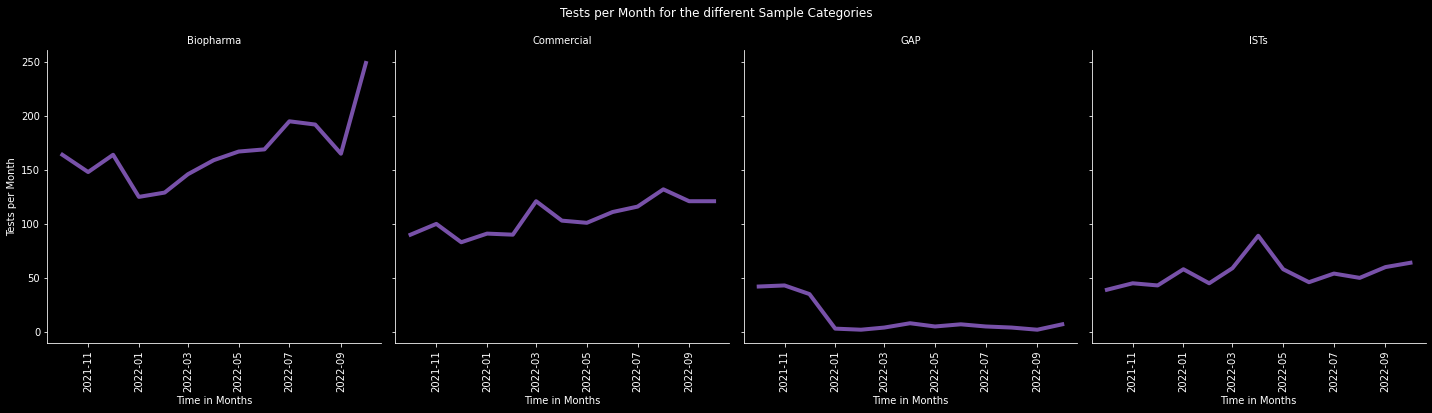

In [1471]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = all_countries_by_type, x = "Year_Month", y = "Sales", kind = "line", col = "Type", color = "#7851a9", linewidth=4 )
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle('Tests per Month for the different Sample Categories', y=1.05)

plt.savefig('facet_plot.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
#files.download("facet_plot.pdf")
plt.show()


In [1472]:
#Total sales across the region
total_sales_regions = top_x_sales.groupby(['Year_Month']).sum().reset_index()


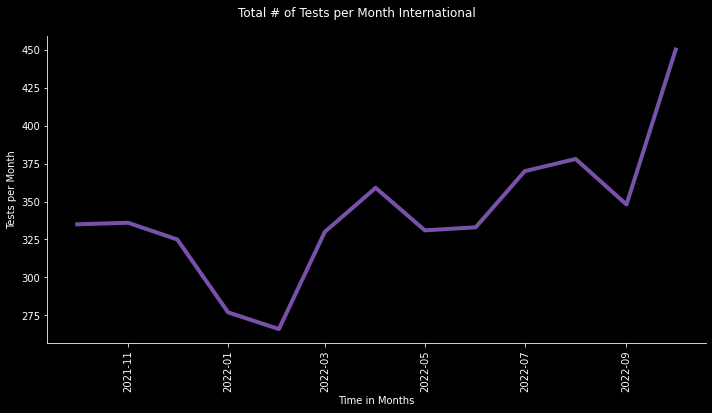

In [1473]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = total_sales_regions, x = "Year_Month", y = "Sales", kind = "line", color = "#7851a9", linewidth=4 ,height=5, aspect=10/5)
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle('Total # of Tests per Month International', y=1.05)

plt.savefig('facet_plot.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
#files.download("facet_plot.pdf")
plt.show()

In [1474]:
#Re-create the stacked area plot used so far


#Create a df in the wide format with the type category providing the new column labels

all_countries_pivot_type = all_countries_by_type.pivot(index = "Year_Month", columns = "Type", values = "Sales")
all_countries_pivot_type.head()


Type,Biopharma,Commercial,GAP,ISTs
Year_Month,,,,
2021-10-01,164,90,42,39
2021-11-01,148,100,43,45
2021-12-01,164,83,35,43
2022-01-01,125,91,3,58
2022-02-01,129,90,2,45


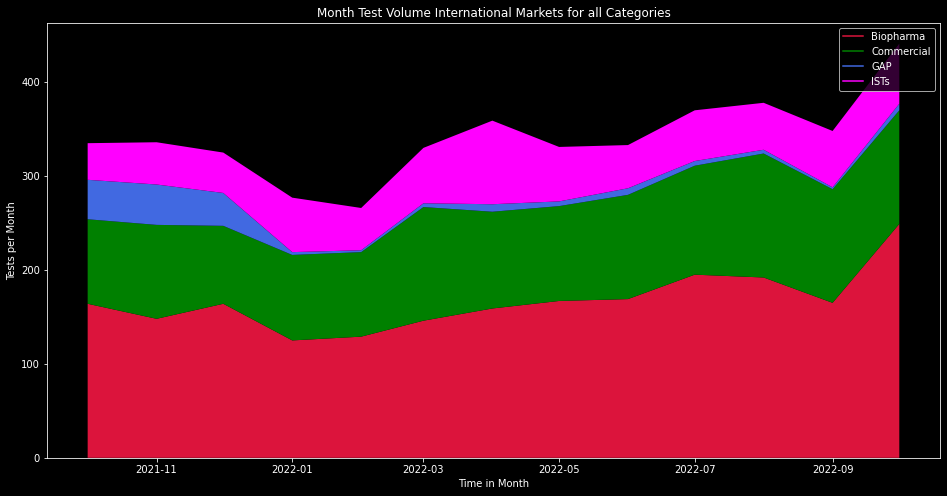

In [1475]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data
plt.plot([], [], color ="crimson",
         label ="Biopharma")
plt.plot([], [], color ='green',
         label ='Commercial')
plt.plot([], [], color ='royalblue',
         label ='GAP')
plt.plot([], [], color ='magenta',
         label ='ISTs')


plt.stackplot(all_countries_pivot_type.index, all_countries_pivot_type["Biopharma"],
              all_countries_pivot_type["Commercial"],
              all_countries_pivot_type["GAP"],
              all_countries_pivot_type["ISTs"],
              colors =["crimson", 'green', 'royalblue', 'magenta'])
 
plt.grid(False)
plt.legend(loc='upper right')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Tests per Month')
 
# Title of Graph
plt.title('Month Test Volume International Markets for all Categories')

 
# Displaying Graph


plt.savefig("test_t.pdf", transparent = True)
#files.download("test_t.pdf")
plt.show()

#### Stacked area plot for Commercial, GAP and ISTS

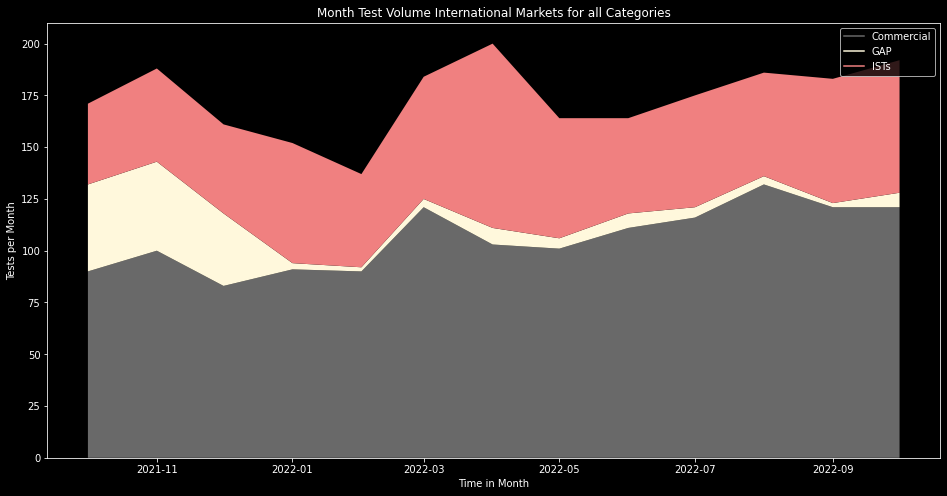

In [1476]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data

plt.plot([], [], color ='dimgrey',
         label ='Commercial')
plt.plot([], [], color ='cornsilk',
         label ='GAP')
plt.plot([], [], color ='lightcoral',
         label ='ISTs')


plt.stackplot(all_countries_pivot_type.index,
              all_countries_pivot_type["Commercial"],
              all_countries_pivot_type["GAP"],
              all_countries_pivot_type["ISTs"],
              colors =['dimgrey', 'cornsilk', 'lightcoral'])
 
plt.grid(False)
plt.legend(loc='upper right')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Tests per Month')
 
# Title of Graph
plt.title('Month Test Volume International Markets for all Categories')

 
# Displaying Graph
plt.show()

#### Plot the relative percentage of sample in each category over time

In [1477]:
all_countries_pivot_type.head()

Type,Biopharma,Commercial,GAP,ISTs
Year_Month,,,,
2021-10-01,164,90,42,39
2021-11-01,148,100,43,45
2021-12-01,164,83,35,43
2022-01-01,125,91,3,58
2022-02-01,129,90,2,45


In [1478]:
all_countries_pivot_type = all_countries_pivot_type.fillna(0)


In [1479]:


all_countries_pivot_type["Total Sales"] = all_countries_pivot_type["Biopharma"] +all_countries_pivot_type["GAP"] + all_countries_pivot_type["Commercial"] + all_countries_pivot_type["ISTs"]

all_countries_pivot_type["Percent Commercial"] = (all_countries_pivot_type["Commercial"]/all_countries_pivot_type["Total Sales"])*100

all_countries_pivot_type["Percent Biopharma"] = (all_countries_pivot_type["Biopharma"]/all_countries_pivot_type["Total Sales"])*100

all_countries_pivot_type["Percent GAP"] = (all_countries_pivot_type["GAP"]/all_countries_pivot_type["Total Sales"])*100

all_countries_pivot_type["Percent ISTs"] = (all_countries_pivot_type["ISTs"]/all_countries_pivot_type["Total Sales"])*100


In [1480]:
all_countries_pivot_type.head(2)

Type,Biopharma,Commercial,GAP,ISTs,Total Sales,Percent Commercial,Percent Biopharma,Percent GAP,Percent ISTs
Year_Month,,,,,,,,,
2021-10-01,164,90,42,39,335,26.87,48.96,12.54,11.64
2021-11-01,148,100,43,45,336,29.76,44.05,12.80,13.39


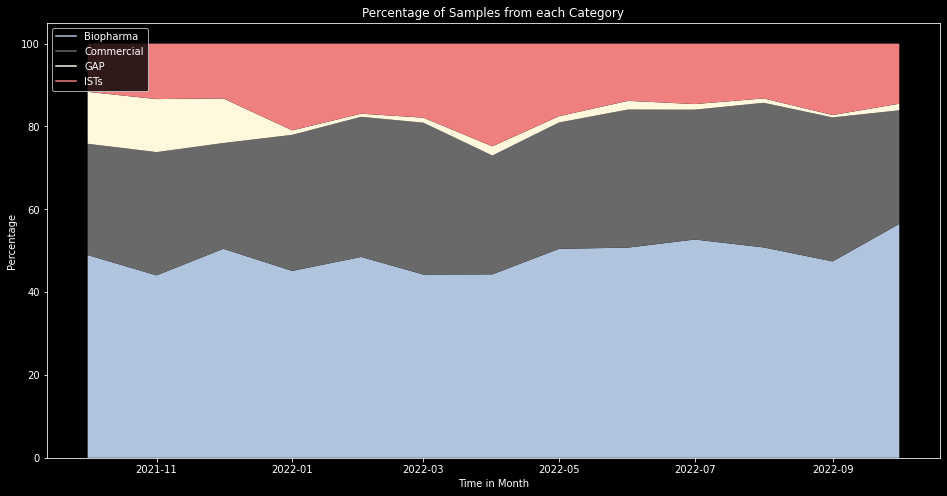

In [1481]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data
plt.plot([], [], color ="lightsteelblue",
         label ="Biopharma")
plt.plot([], [], color ='dimgrey',
         label ='Commercial')
plt.plot([], [], color ='cornsilk',
         label ='GAP')
plt.plot([], [], color ='lightcoral',
         label ='ISTs')


plt.stackplot(all_countries_pivot_type.index, all_countries_pivot_type["Percent Biopharma"],
              all_countries_pivot_type["Percent Commercial"],
              all_countries_pivot_type["Percent GAP"],
              all_countries_pivot_type["Percent ISTs"],
              colors =["lightsteelblue", 'dimgrey', 'cornsilk', 'lightcoral'])
 
plt.grid(False)
plt.legend(loc='upper left')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Percentage')
 
# Title of Graph
plt.title('Percentage of Samples from each Category')

 
# Displaying Graph
plt.show()

#### Add second y axis

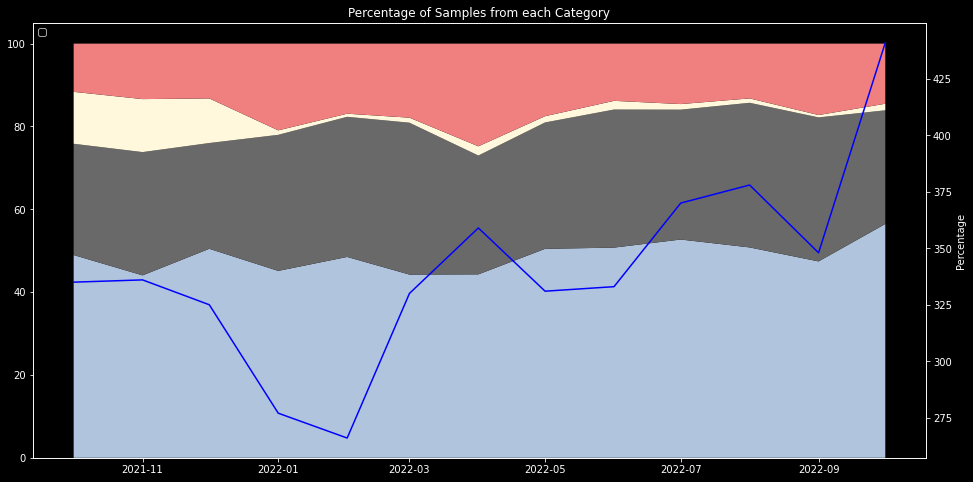

In [1482]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')


fig, ax = plt.subplots(1,1, figsize = (16, 8))

ax2 = ax.twinx()

# Plot x-labels, y-label and data
ax.plot([], [], color ="lightsteelblue",
         label ="Biopharma")
ax.plot([], [], color ='dimgrey',
         label ='Commercial')
ax.plot([], [], color ='cornsilk',
         label ='GAP')
ax.plot([], [], color ='lightcoral',
         label ='ISTs')


ax.stackplot(all_countries_pivot_type.index, all_countries_pivot_type["Percent Biopharma"],
              all_countries_pivot_type["Percent Commercial"],
              all_countries_pivot_type["Percent GAP"],
              all_countries_pivot_type["Percent ISTs"],
              colors =["lightsteelblue", 'dimgrey', 'cornsilk', 'lightcoral'])

ax2.plot(all_countries_pivot_type.index, all_countries_pivot_type["Total Sales"], color = 'b')
 
plt.grid(False)
plt.legend(loc='upper left')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Percentage')
 
# Title of Graph
plt.title('Percentage of Samples from each Category')

 
# Displaying Graph
plt.show()

# Analysing the breakdown of commercial samples

In [1483]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Accession #            3749 non-null   object        
 1   Reporting Country      3749 non-null   object        
 2   Billing Type           3749 non-null   object        
 3   LIMS Project ID        3749 non-null   object        
 4   Account: Account Name  3749 non-null   object        
 5   Contact: Full Name     3749 non-null   object        
 6   Final Report Date      3715 non-null   object        
 7   Test Type              3749 non-null   object        
 8   Cancer Type            1256 non-null   object        
 9   Type                   3749 non-null   category      
 10  AE_supported           3749 non-null   object        
 11  Currency               3749 non-null   object        
 12  Sub_region             3749 non-null   object        
 13  Mon

In [1484]:
#Select the time horizion to analyse
start_date_com = "2020-10-01"
end_date_com = "2022-10-31"
#Select the # of countries to be analyses based on the maxiumum number of samplesin 
#the time horizon
num_countries_comm = 20
#The the Year_Month columns as index to allow for easier slicing
df_merged = df_merged.set_index("Year_Month").sort_index()
#Create the dataframe relevant for the time periode which should be analysed
df_merged_time_horizon = df_merged.loc[start_date_com:end_date_com].copy().reset_index()
print(f"The total number of samples in this dataframe is {df_merged_time_horizon.shape[0]}")

The total number of samples in this dataframe is 2810


In [1485]:
df_merged_time_horizon["Reporting Country"].value_counts()

UNITED KINGDOM     1406
SPAIN               506
TURKEY              242
BRAZIL              230
CANADA               90
IRELAND              58
MEXICO               57
GERMANY              51
FINLAND              38
CHILE                29
FRANCE               26
ITALY                25
LITHUANIA            10
AUSTRIA               7
ROMANIA               5
BELGIUM               4
GREECE                4
SWITZERLAND           4
COLOMBIA              4
ARGENTINA             3
SLOVENIA              3
NORTH MACEDONIA       2
POLAND                2
PERU                  1
LUXEMBOURG            1
COSTA RICA            1
PORTUGAL              1
Name: Reporting Country, dtype: int64

In [1486]:
#identiy the top commercial countries
df_merged_time_horizon["FOC"] = df_merged_time_horizon["FOC"].astype("string")

#Create the dataframe relevant for the time periode which should be analysed

print(f"The total number of samples in this dataframe is {df_merged_time_horizon.shape[0]}")


The total number of samples in this dataframe is 2810


In [1487]:
df_merged_time_horizon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year_Month             2810 non-null   datetime64[ns]
 1   Accession #            2810 non-null   object        
 2   Reporting Country      2810 non-null   object        
 3   Billing Type           2810 non-null   object        
 4   LIMS Project ID        2810 non-null   object        
 5   Account: Account Name  2810 non-null   object        
 6   Contact: Full Name     2810 non-null   object        
 7   Final Report Date      2807 non-null   object        
 8   Test Type              2810 non-null   object        
 9   Cancer Type            939 non-null    object        
 10  Type                   2810 non-null   category      
 11  AE_supported           2810 non-null   object        
 12  Currency               2810 non-null   object        
 13  Sub

In [1488]:
#Create a dataframe with just the topx countries by number of tests sold
#top_comm_x = df_merged_time_horizon.groupby('Reporting Country').sum().sort_values("Sales",ascending = False).head(num_countries_comm)
#top_comm_x_list = top_comm_x.index.tolist()
#List of countries based on Ian's input
country_list = ['UNITED KINGDOM', 'SPAIN', 'BRAZIL', 'TURKEY', 'CANADA',"FRANCE", "Italy" ]
top_comm_x_sales =df_merged_time_horizon[df_merged_time_horizon['Reporting Country'].isin(country_list)]
print(f"The top 7 countries have {top_comm_x_sales.shape[0]} samples which represents {top_comm_x_sales.shape[0]/df_merged_time_horizon.shape[0]:.2%}")

The top 7 countries have 2500 samples which represents 88.97%


In [1489]:
#top_comm_x_list

In [1490]:
#merged_top_x_countries = df_merged[df_merged['Reporting Country'].isin(top_comm_x_list)]
#merged_top_x_countries["Reporting Country"].value_counts()

In [1491]:
list_for_FOC_analysis = [
 'Reporting Country',
 'Type',
 'Sales', 'FOC',
 'Year_Month']

In [1492]:
#Create the main data frame for the further analysis
commercial_sales_FOC_analysis_df = top_comm_x_sales[list_for_FOC_analysis]
commercial_sales_FOC_analysis_df["FOC"] = commercial_sales_FOC_analysis_df["FOC"].astype("category")

#This is the main dataframe
commercial_sales_FOC_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2809
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Reporting Country  2500 non-null   object        
 1   Type               2500 non-null   category      
 2   Sales              2500 non-null   int64         
 3   FOC                2500 non-null   category      
 4   Year_Month         2500 non-null   datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(1), object(1)
memory usage: 83.3+ KB


In [1493]:
commercial_sales_FOC_analysis_df["FOC"].value_counts()

Paid    1964
Free     536
Name: FOC, dtype: int64

In [1494]:
FOC_df = commercial_sales_FOC_analysis_df.groupby(['Year_Month','Reporting Country', "FOC"]).sum().reset_index()
FOC_df.tail()


,Year_Month,Reporting Country,FOC,Sales
295,2022-10-01,SPAIN,Paid,17
296,2022-10-01,TURKEY,Free,0
297,2022-10-01,TURKEY,Paid,17
298,2022-10-01,UNITED KINGDOM,Free,27
299,2022-10-01,UNITED KINGDOM,Paid,52


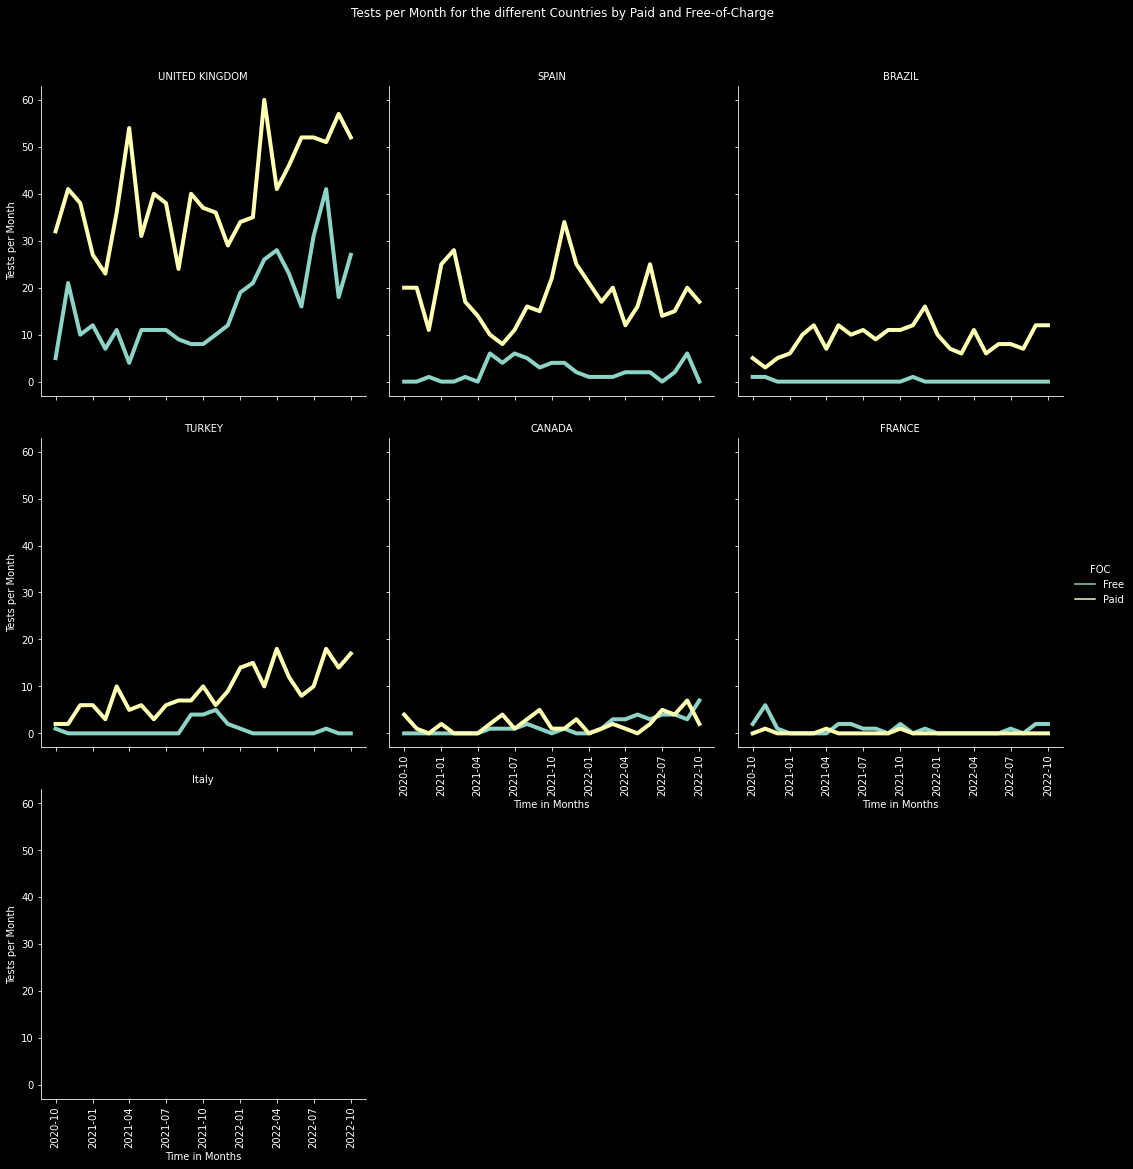

In [1495]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = FOC_df, x = "Year_Month", y = "Sales", kind = "line", hue = "FOC", col = "Reporting Country", color = "#7851a9", linewidth=4 , ci = None, col_wrap = 3
                ,col_order = country_list
                )
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle('Tests per Month for the different Countries by Paid and Free-of-Charge', y=1.05)

plt.savefig('comm.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
#files.download("comm.pdf")
plt.show()


In [1496]:
#Total sales
all_countries_comm = commercial_sales_FOC_analysis_df.groupby(['Year_Month', "FOC"]).sum().reset_index()
all_countries_comm.sample(3)

,Year_Month,FOC,Sales
21,2021-08-01,Paid,59
15,2021-05-01,Paid,61
47,2022-09-01,Paid,110


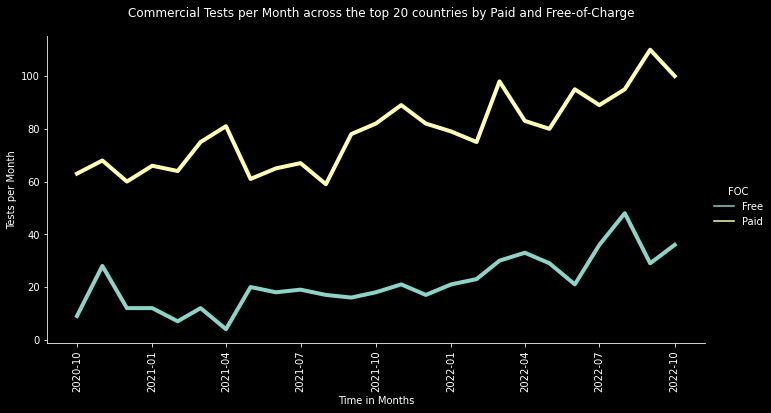

In [1497]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = all_countries_comm , x = "Year_Month", y = "Sales", kind = "line", hue = "FOC",  color = "#7851a9", linewidth=4 , 
                ci = None, height=5, aspect=10/5)
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle(f"Commercial Tests per Month across the top {num_countries_comm} countries by Paid and Free-of-Charge", y=1.05)

plt.savefig('comm_all.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
#files.download("comm_all.pdf")
plt.show()

In [1498]:
#All Commercial cases including free
all_countries_incl_free = commercial_sales_FOC_analysis_df.groupby(['Year_Month']).sum().reset_index()
all_countries_incl_free.head()

,Year_Month,Sales
0,2020-10-01,72
1,2020-11-01,96
2,2020-12-01,72
3,2021-01-01,78
4,2021-02-01,71


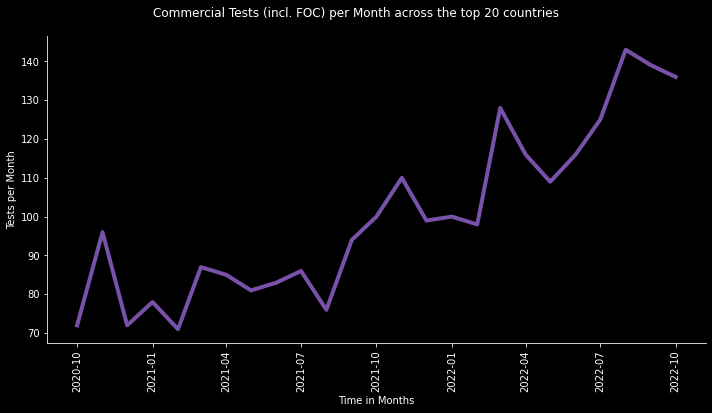

In [1499]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = all_countries_incl_free  , x = "Year_Month", y = "Sales", kind = "line",  color = "#7851a9", linewidth=4 , 
                ci = None, height=5, aspect=10/5)
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle(f"Commercial Tests (incl. FOC) per Month across the top {num_countries_comm} countries", y=1.05)

plt.savefig('comm_all_with_FOC.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
#files.download("comm_all_with_FOC.pdf")
plt.show()

# Rolling Mean Analysis

In [1500]:

commercial_sales_rolling_df = commercial_sales_FOC_analysis_df.groupby(["Year_Month"])["Sales"].sum().reset_index()

In [1501]:
commercial_sales_rolling_df["Rolling 3-Month Average"] = commercial_sales_rolling_df["Sales"].rolling(3).mean()

In [1502]:
commercial_sales_rolling_df.head()

,Year_Month,Sales,Rolling 3-Month Average
0,2020-10-01,72,NaN
1,2020-11-01,96,NaN
2,2020-12-01,72,80.00
3,2021-01-01,78,82.00
4,2021-02-01,71,73.67


In [1503]:
melt = commercial_sales_rolling_df.melt(id_vars = "Year_Month", value_vars = ["Sales", "Rolling 3-Month Average"], value_name= "Smoothed Sales")

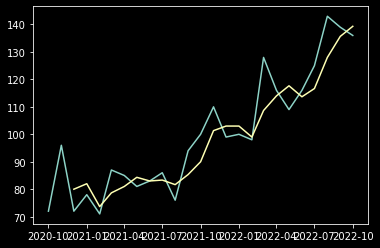

In [1504]:
fig, ax = plt.subplots()
ax.plot(commercial_sales_rolling_df["Year_Month"],commercial_sales_rolling_df["Sales"])
ax.plot(commercial_sales_rolling_df["Year_Month"],commercial_sales_rolling_df["Rolling 3-Month Average"])
plt.show()

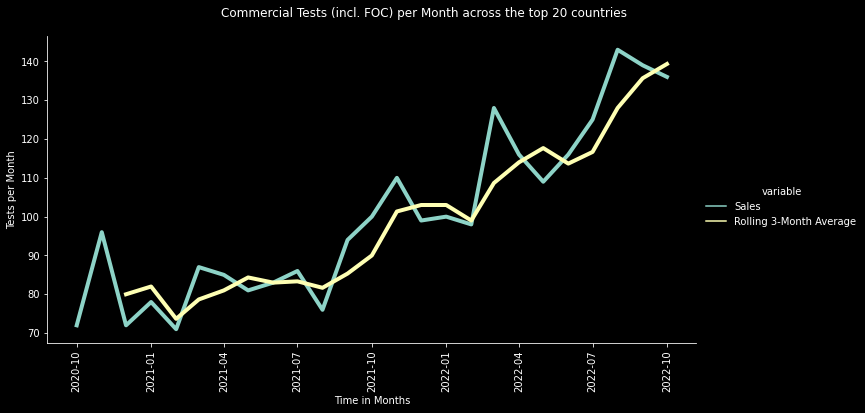

In [1505]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = melt  , x = "Year_Month", y = "Smoothed Sales", hue = "variable", kind = "line",  color = "#7851a9",
                linewidth=4 , 
                ci = None, height=5, aspect=10/5)

g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle(f"Commercial Tests (incl. FOC) per Month across the top {num_countries_comm} countries", y=1.05)

#plt.savefig('comm_all_with_FOC.pdf', dpi = 300, bbox_inches ="tight",
            #pad_inches = 1)
#files.download("comm_all_with_FOC.pdf")
plt.show()

# Percentages growth

In [1506]:
commercial_sales_FOC_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2809
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Reporting Country  2500 non-null   object        
 1   Type               2500 non-null   category      
 2   Sales              2500 non-null   int64         
 3   FOC                2500 non-null   category      
 4   Year_Month         2500 non-null   datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(1), object(1)
memory usage: 83.3+ KB


In [1507]:
commercial_sales_FOC_analysis_df.head()

,Reporting Country,Type,Sales,FOC,Year_Month
0,UNITED KINGDOM,Commercial,1,Paid,2020-10-01
1,BRAZIL,Commercial,1,Paid,2020-10-01
3,SPAIN,Commercial,1,Paid,2020-10-01
4,SPAIN,Commercial,1,Paid,2020-10-01
5,UNITED KINGDOM,Commercial,1,Paid,2020-10-01


In [1508]:
#Creat a data set with the monthly revenue for all countries, Calcualte the percent growth by using the percent_change function
commercial_percent = commercial_sales_FOC_analysis_df.groupby(["Year_Month"]).sum().reset_index().set_index("Year_Month")

In [1509]:
commercial_percent["Annual_Growth(%)"] = commercial_percent.pct_change(periods = 12).mul(100)

In [1510]:
commercial_percent.tail()

,Sales,Annual_Growth(%)
Year_Month,,
2022-06-01,116,39.76
2022-07-01,125,45.35
2022-08-01,143,88.16
2022-09-01,139,47.87
2022-10-01,136,36.00


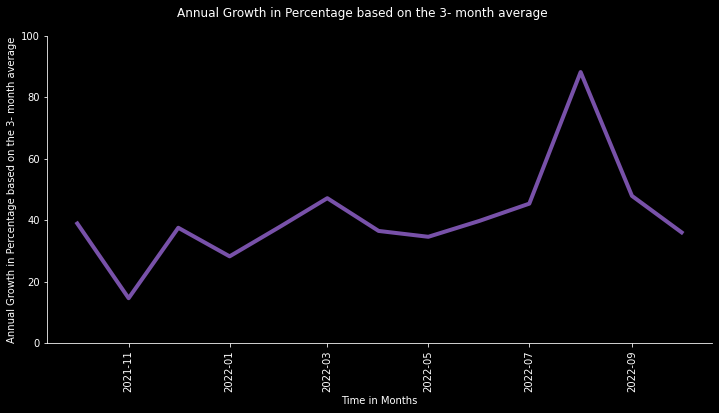

In [1511]:
#Plot the sales for each category over time
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = commercial_percent  , x = "Year_Month", y = "Annual_Growth(%)", kind = "line",  color = "#7851a9", linewidth=4 , 
                ci = None, height=5, aspect=10/5)
g.set_xticklabels(rotation = "90")

g.set(ylim = (0,100))
g.set_ylabels("Annual Growth in Percentage based on the 3- month average")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle(f"Annual Growth in Percentage based on the 3- month average", y=1.05)

#plt.savefig('comm_all_with_FOC.pdf', dpi = 300, bbox_inches ="tight",
            #pad_inches = 1)
#files.download("comm_all_with_FOC.pdf")
plt.show()

In [1512]:
#Calculate the percentage growth based on the 3 month rolling mean
commercial_sales_rolling_df["Percent_growth_3_month_average"] = commercial_sales_rolling_df.set_index("Year_Month")["Rolling 3-Month Average"].pct_change(periods=6).mul(100)

In [1513]:
#commercial_sales_rolling_df

# Charts for Rev Core

In [1514]:
#Chart 1

In [1515]:
countries_df.reset_index()

,Year_Month,Accession #,Reporting Country,Type,Sales,Sub_region,AE_supported,Currency
0,2021-10-01,A0408560,ITALY,Lunar,1,Europe,non_AE,EUR
1,2021-10-01,A0408561,ITALY,Lunar,1,Europe,non_AE,EUR
2,2021-10-01,A0409033,ITALY,Lunar,1,Europe,non_AE,EUR
3,2021-10-01,A0409034,ITALY,Lunar,1,Europe,non_AE,EUR
4,2021-10-01,A0410234,SPAIN,Lunar,1,Europe,AE,EUR
...,...,...,...,...,...,...,...,...
5594,2022-10-01,A0591496,SPAIN,Biopharma,1,Europe,AE,EUR
5595,2022-10-01,A0594281,FRANCE,Biopharma,1,Europe,non_AE,EUR
5596,2022-10-01,A0600274,BELGIUM,Biopharma,1,Europe,non_AE,EUR
5597,2022-10-01,A0594228,FRANCE,Biopharma,1,Europe,non_AE,EUR


In [1516]:
countries_df.groupby(["Year_Month", "Sub_region", "Type"])["Sales"].sum().reset_index().tail(10)

,Year_Month,Sub_region,Type,Sales
120,2022-10-01,Americas,Biopharma,29
121,2022-10-01,Americas,Commercial,28
122,2022-10-01,Americas,GAP,0
123,2022-10-01,Americas,GH Trials (Prospective),0
124,2022-10-01,Americas,Lunar,11
125,2022-10-01,Europe,Biopharma,274
126,2022-10-01,Europe,Commercial,123
127,2022-10-01,Europe,GAP,7
128,2022-10-01,Europe,GH Trials (Prospective),15
129,2022-10-01,Europe,Lunar,49


In [1517]:
# Figure out the commercial volume by region in October 2022

In [1518]:
df_merged_time_horizon.groupby(["Year_Month", "Sub_region"])["Sales"].sum().reset_index()

,Year_Month,Sub_region,Sales
0,2020-10-01,Americas,14
1,2020-10-01,Europe,71
2,2020-11-01,Americas,10
3,2020-11-01,Europe,100
4,2020-12-01,Americas,8
5,2020-12-01,Europe,73
6,2021-01-01,Americas,17
7,2021-01-01,Europe,76
8,2021-02-01,Americas,14
9,2021-02-01,Europe,70


In [1519]:
df_merged_time_horizon.head()

,Year_Month,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Month_to_match,FOC,Invoiced Amount
0,2020-10-01,A0294261,UNITED KINGDOM,Self-Pay Sponsored,GHI_01,The Royal Marsden NHS Foundation Trust,Nicholas Turner,10/20/2020,Guardant 360,Breast,Commercial,AE,GBP,Europe,10,2020,4,1,2020-10,Paid,1245.0
1,2020-10-01,A0294184,BRAZIL,Distributors : ROW,GHI_01,Diagnosticos da America S.A.,Cristovam Scapulatempo Neto,10/18/2020,Guardant 360,Breast,Commercial,AE,USD,Americas,10,2020,4,1,2020-10,Paid,2000.0
2,2020-10-01,A0294196,GERMANY,Self-Pay Sponsored,GHI_01,Onkologie im Elisenhof,Christof Fischer,10/18/2020,Guardant 360,Kidney,Commercial,non_AE,EUR,Europe,10,2020,4,1,2020-10,Paid,3490.0
3,2020-10-01,A0294207,SPAIN,Self-Pay Sponsored,GHI_01,Centro de Patologia de la Mama-Fundacion Tejerina,Ana de Lara Gonzalez,10/18/2020,Guardant 360,Breast,Commercial,AE,EUR,Europe,10,2020,4,1,2020-10,Paid,1735.0
4,2020-10-01,A0294215,SPAIN,Distributors : ROW,GHI_01,Hospital Universitario HM Sanchinarro,Antonio Cubillo Gracian,10/18/2020,Guardant 360,NaN,Commercial,AE,EUR,Europe,10,2020,4,1,2020-10,Paid,2500.0


AE vs non_AE countries

In [1520]:
AE_analysis = df_merged_time_horizon.groupby(["Year_Month", "AE_supported"])["Sales"].sum().reset_index()

In [1521]:
AE_analysis

,Year_Month,AE_supported,Sales
0,2020-10-01,AE,71
1,2020-10-01,non_AE,14
2,2020-11-01,AE,91
3,2020-11-01,non_AE,19
4,2020-12-01,AE,72
5,2020-12-01,non_AE,9
6,2021-01-01,AE,78
7,2021-01-01,non_AE,15
8,2021-02-01,AE,72
9,2021-02-01,non_AE,12


In [1522]:
AE_pivot = AE_analysis.pivot(index = "Year_Month", columns = "AE_supported", values = "Sales")

In [1523]:
AE_pivot.tail()

AE_supported,AE,non_AE
Year_Month,,
2022-06-01,121,14
2022-07-01,127,10
2022-08-01,144,6
2022-09-01,138,8
2022-10-01,135,15


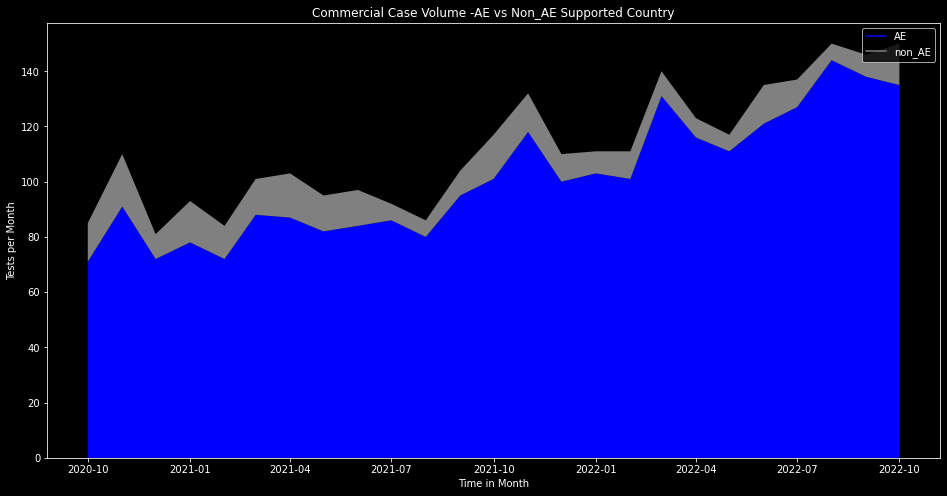

In [1524]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data
plt.plot([], [], color ="blue",
         label ="AE")
plt.plot([], [], color ='grey',
         label ='non_AE')



plt.stackplot(AE_pivot.index, AE_pivot["AE"],
              AE_pivot["non_AE"],
             
              colors =["blue", 'grey'])
 
plt.grid(False)
plt.legend(loc='upper right')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Tests per Month')
 
# Title of Graph
plt.title('Commercial Case Volume -AE vs Non_AE Supported Country')

 
# Displaying Graph


plt.savefig("test_t.pdf", transparent = True)
#files.download("test_t.pdf")
plt.show()

In [1525]:
# Commercial volume 

In [1526]:
top_commercial_countries = top_comm_x_sales.groupby(["Year_Month", "Reporting Country"])["Sales"].sum().reset_index()
top_commercial_countries.head()

,Year_Month,Reporting Country,Sales
0,2020-10-01,BRAZIL,6
1,2020-10-01,CANADA,4
2,2020-10-01,FRANCE,2
3,2020-10-01,SPAIN,20
4,2020-10-01,TURKEY,3


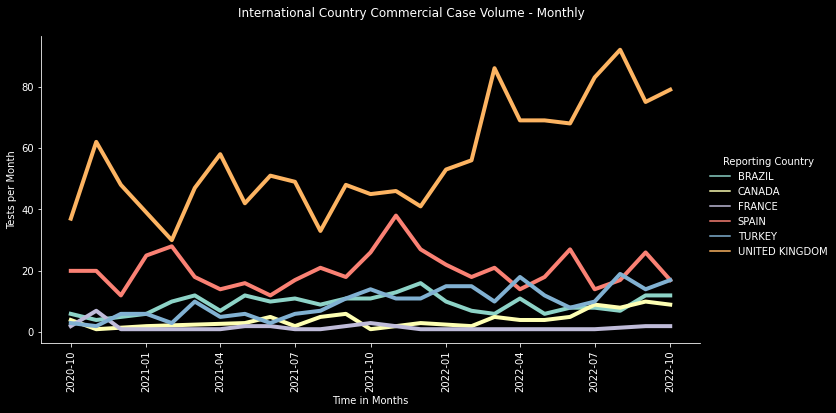

In [1527]:
#sns.set_style("whitegrid")
with mpl.rc_context({'axes.grid': False}):
  g = sns.relplot(data = top_commercial_countries  , x = "Year_Month", y = "Sales", hue = "Reporting Country", kind = "line",
                linewidth=4 , ci = None, height=5, aspect=10/5)

g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle(f"International Country Commercial Case Volume - Monthly", y=1.05)

#plt.savefig('comm_all_with_FOC.pdf', dpi = 300, bbox_inches ="tight",
            #pad_inches = 1)
#files.download("comm_all_with_FOC.pdf")
plt.show()

# Frequency plots

In [1528]:
df_merged_time_horizon.sample(3)

,Year_Month,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Month_to_match,FOC,Invoiced Amount
53,2020-10-01,A0297835,SPAIN,Distributors : ROW,GHI_01,Hospital Clinico Provincial de Barcelona,Noemi Reguart,10/31/2020,Guardant 360,NaN,Commercial,AE,EUR,Europe,10,2020,4,1,2020-10,Paid,2200.0
2292,2022-07-01,A0542470,IRELAND,Self-Pay Patient,GHI_19,Bon Secours Hospital,Brian Bird,7/15/2022,Guardant360 CDx EU,NaN,Commercial,AE,EUR,Europe,7,2022,3,1,2022-7,Paid,1245 EUR
537,2021-03-01,A0338085,BRAZIL,Distributors : ROW,GHI_01,Diagnosticos da America S.A.,Cristovam Scapulatempo Neto,3/23/2021,Guardant 360,NaN,Commercial,AE,USD,Americas,3,2021,1,1,2021-3,Paid,1350.0


In [1529]:
all_clini = df_merged_time_horizon["Contact: Full Name"].tolist()

In [1530]:
unique_clinician = set(all_clini)

# Productionized version of three monthly clinician ordering frequency

In [1531]:
#Input dataframe
input_df_freq_count = df_merged_time_horizon
#Define the list of countries
countries_clinician_list = [ 'SPAIN' ]


In [1532]:
#Helper function
def count_clinician(num):
  if num > 4:
    return "More than five"
  if num > 1 & num <=4:
    return  "Between 2 to 5 test"
  if num == 1:
    return "One test in three months"

In [1533]:
#Select a dataframe with the rows for the specific country
freq_country_df= input_df_freq_count[input_df_freq_count['Reporting Country'].isin(countries_clinician_list)].set_index("Year_Month")
freq_country_df.tail()

,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Month_to_match,FOC,Invoiced Amount
Year_Month,,,,,,,,,,,,,,,,,,,,
2022-10-01,A0602383,SPAIN,Distributors : ROW,GH2_12,Clinica Universidad de Navarra-Madrid,Gonzalo Fernandez Hinojal,11/2/2022,Guardant 360,NaN,Commercial,AE,EUR,Europe,10,2022,4,1,2022-10,Paid,2400 USD
2022-10-01,A0602378,SPAIN,Do Not Bill - Cancelled,GH2_12,Clinica Universidad de Navarra-Madrid,Gonzalo Fernandez Hinojal,NaN,Guardant 360,NaN,Commercial,AE,EUR,Europe,10,2022,4,1,2022-10,Paid,0 EUR
2022-10-01,A0597820,SPAIN,Distributors : ROW,GH2_12,Hospital Quiron Barcelona,Aleix Prat,10/28/2022,Guardant 360,Breast,Commercial,AE,EUR,Europe,10,2022,4,1,2022-10,Paid,2241 EUR
2022-10-01,A0586616,SPAIN,Distributors : ROW,GHI_19,Hospital Clinico Provincial de Barcelona,Noemi Reguart,10/11/2022,Guardant360 CDx EU,NaN,Commercial,AE,EUR,Europe,10,2022,4,1,2022-10,Paid,1245 EUR
2022-10-01,A0601880,SPAIN,Distributors : ROW,GHI_01,Clinica Universidad de Navarra-Madrid,Javier Rodriguez,11/11/2022,Guardant 360,NaN,Commercial,AE,EUR,Europe,10,2022,4,1,2022-10,Paid,2400 USD


In [1534]:
start_date_freq = "2021-10-01"
end_date_freq = "2022-10-31"
lookback_periode = 3 # in month
lookback_periode_slice = lookback_periode
#list_countries_freq = ["Spain"]
list_month = pd.date_range(start = start_date_freq, end = end_date_freq, freq = "M")


In [1535]:
from pandas.tseries.frequencies import DateOffset




# intermediate_start = pd.to_datetime(start_date_freq) + DateOffset(months = lookback_periode)
# intermediate_end = pd.to_datetime(intermediate_start) + DateOffset(months = lookback_periode)

In [1536]:
#dataframe = pd.DataFrame(columns=["Date", "Freq_Categories",  "Frequency"])
data = []
for month in list_month[lookback_periode_slice:]:
  intermediate_end = pd.to_datetime(month)
  intermediate_start = intermediate_end - DateOffset(months = lookback_periode)
  #print(intermediate_end)
  #print(intermediate_start)
  Interim_fre_df_1 = freq_country_df[intermediate_start:intermediate_end]
  #Interim_fre_df_2 = Interim_fre_df_1[Interim_fre_df_1["Reporting Country"].isin(list_countries_freq)]
  Interim_fre_df_3 = Interim_fre_df_1["Contact: Full Name"].value_counts()
  interim_freq_dict = {"Frequency": Interim_fre_df_3, "Date" : intermediate_start}
  freq_counts = pd.DataFrame(interim_freq_dict)
  freq_counts["Freq_Categories"] = freq_counts["Frequency"].apply(count_clinician)
  final = freq_counts.groupby(["Date", "Freq_Categories"])["Frequency"].count().reset_index()
  intermediate_start = intermediate_start + DateOffset(months = 1)
  data.append(final)

In [1537]:
freq_plot_df = pd.concat(data)
freq_plot_df.tail()

,Date,Freq_Categories,Frequency
1,2022-06-30,More than five,3
2,2022-06-30,One test in three months,9
0,2022-07-31,Between 2 to 5 test,10
1,2022-07-31,More than five,3
2,2022-07-31,One test in three months,14


In [1538]:
dd = freq_plot_df.pivot(index= "Date", columns = "Freq_Categories", values = "Frequency").reset_index()
dd = dd.melt(id_vars= "Date", value_name= "Frequency")
dd.sample(3)

,Date,Freq_Categories,Frequency
7,2022-05-31,Between 2 to 5 test,9.0
6,2022-04-30,Between 2 to 5 test,5.0
18,2022-06-30,More than five,3.0


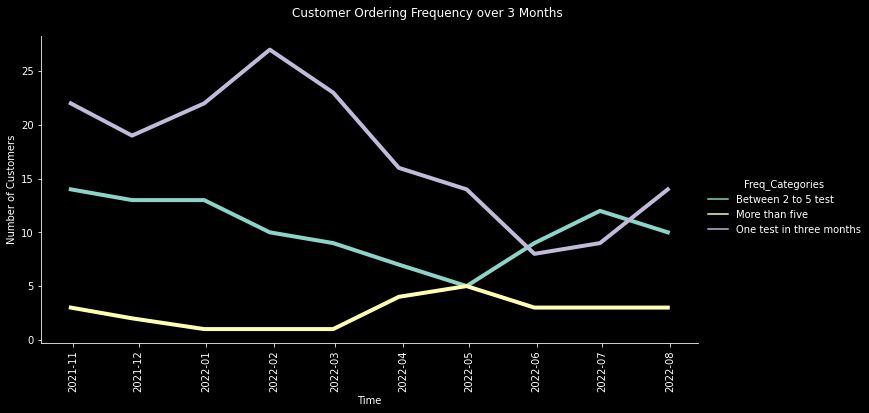

In [1539]:
with mpl.rc_context({'axes.grid': False}): 
  g = sns.relplot(data = dd  , x = "Date", y = "Frequency", hue = "Freq_Categories", kind = "line",
                linewidth=4 , ci = None, height=5, aspect=10/5)

g.set_xticklabels(rotation = "90")

g.set_ylabels("Number of Customers")
g.set_xlabels("Time")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle(f"Customer Ordering Frequency over 3 Months", y=1.05)

#plt.savefig('comm_all_with_FOC.pdf', dpi = 300, bbox_inches ="tight",
            #pad_inches = 1)
#files.download("comm_all_with_FOC.pdf")
plt.show()

# Revenue Analysis

In [1540]:
#Create the data farme that will be used for revenue analysis
revenue_start = df_merged_time_horizon.copy()
revenue_start["Invoiced Amount"] = revenue_start["Invoiced Amount"].astype("string")
revenue_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year_Month             2810 non-null   datetime64[ns]
 1   Accession #            2810 non-null   object        
 2   Reporting Country      2810 non-null   object        
 3   Billing Type           2810 non-null   object        
 4   LIMS Project ID        2810 non-null   object        
 5   Account: Account Name  2810 non-null   object        
 6   Contact: Full Name     2810 non-null   object        
 7   Final Report Date      2807 non-null   object        
 8   Test Type              2810 non-null   object        
 9   Cancer Type            939 non-null    object        
 10  Type                   2810 non-null   category      
 11  AE_supported           2810 non-null   object        
 12  Currency               2810 non-null   object        
 13  Sub

In [1541]:
revenue_start["Revenue(Local_Curr)"] = revenue_start["Invoiced Amount"].str.extract('(\d+,?\d*)')
revenue_start["Revenue(Local_Curr)"] = revenue_start["Revenue(Local_Curr)"].fillna("0")
revenue_start["Revenue(Local_Curr)"] = revenue_start["Revenue(Local_Curr)"].str.replace(",","")
revenue_start["Revenue(Local_Curr)"] = revenue_start["Revenue(Local_Curr)"].astype(float)

In [1542]:
lookup_currency["Date"] = lookup_currency.index.to_numpy().astype('datetime64[M]').astype(str)
lookup_currency_wide = lookup_currency
lookup_currency_wide.head(3)



,EUR,GBP,old,Unnamed: 4,USD,Date
Month,,,,,,
2015-08-01,1.11,1.56,2022-08-15,NaN,1,2015-08
2015-09-01,1.12,1.53,2022-09-15,NaN,1,2015-09
2015-10-01,1.12,1.53,2022-10-15,NaN,1,2015-10


In [1543]:
lookup_currency_long = lookup_currency_wide.melt(id_vars = ["Date"], value_vars = ["EUR", "GBP", "USD"], var_name = "Currency", value_name = "Value")
#lookup_currency.tail(3)


In [1544]:
lookup_currency_long

,Date,Currency,Value
0,2015-08,EUR,1.11
1,2015-09,EUR,1.12
2,2015-10,EUR,1.12
3,2015-11,EUR,1.07
4,2015-12,EUR,1.09
...,...,...,...
256,2022-06,USD,1.00
257,2022-07,USD,1.00
258,2022-08,USD,1.00
259,2022-09,USD,1.00


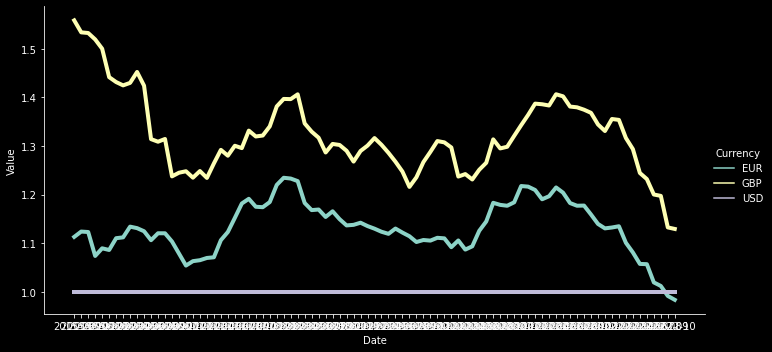

In [1545]:
#Helper plot to understand if their are iutliers in the currency data
#lookup_currency_long.plot(x = "Date", y = "Value", hue = "Currency")
sns.relplot(data = lookup_currency_long , x = "Date", y = "Value", hue = "Currency", kind = "line",
                linewidth=4 , ci = None, height=5, aspect=10/5)


In [1546]:
# Create a string based column that can be used to lookup a columnb value in other table - Specifically the month_year date
revenue_start["Month_to_match"] = revenue_start["Year_Month"].dt.to_period('M').astype(str)
#revenue_start["Month_to_match"].astype(str).unique().tolist()

# Create a string based column that can be used to lookup a column value in other table - Specifically the currency

In [1547]:
revenue_start.shape

(2810, 23)

In [1548]:
lookup_currency_long.head(3)


,Date,Currency,Value
0,2015-08,EUR,1.11
1,2015-09,EUR,1.12
2,2015-10,EUR,1.12


In [1549]:
revenue = revenue_start.merge(lookup_currency_long, left_on = ["Month_to_match", "Currency"], right_on = ["Date", "Currency"])
revenue.shape

(2810, 25)

In [1550]:
revenue.sample(3)

,Year_Month,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Month_to_match,FOC,Invoiced Amount,Revenue(Local_Curr),Exchange_rate,Date,Value
232,2020-12-01,A0312834,UNITED KINGDOM,Self-Pay Patient,GHI_01,BMI Cavell Hospital,Stephen Karp,12/21/2020,Guardant 360,NaN,Commercial,AE,GBP,Europe,12,2020,4,1,2020-12,Paid,2490.0,2490.0,1,2020-12,1.34
1572,2022-01-01,A0456257,UNITED KINGDOM,Self-Pay Patient,GHI_01,Poole Hospital NHS Foundation Trust,Lauren Gorf,1/24/2022,Guardant 360,NaN,Commercial,AE,GBP,Europe,1,2022,1,1,2022-01,Free,0 GBP,0.0,1,2022-01,1.36
1621,2022-02-01,A0471061,BRAZIL,Distributors : ROW,GHI_01,Diagnosticos da America S.A.,Cristovam Scapulatempo Neto,3/1/2022,Guardant 360,NaN,Commercial,AE,USD,Americas,2,2022,1,1,2022-02,Paid,1350 USD,1350.0,1,2022-02,1.00


In [1551]:
revenue["Revenue (USD)"] = revenue["Revenue(Local_Curr)"]*revenue["Value"]

In [1553]:
revenue.head(3)

,Year_Month,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Month_to_match,FOC,Invoiced Amount,Revenue(Local_Curr),Exchange_rate,Date,Value,Revenue (USD)
0,2020-10-01,A0294261,UNITED KINGDOM,Self-Pay Sponsored,GHI_01,The Royal Marsden NHS Foundation Trust,Nicholas Turner,10/20/2020,Guardant 360,Breast,Commercial,AE,GBP,Europe,10,2020,4,1,2020-10,Paid,1245.0,1245.0,1,2020-10,1.3,1616.51
1,2020-10-01,A0294546,UNITED KINGDOM,Self-Pay Sponsored,GHI_01,Western General Hospital - Edinburgh Cancer Ce...,Alan Christie,10/18/2020,Guardant 360,NaN,Commercial,AE,GBP,Europe,10,2020,4,1,2020-10,Paid,2490.0,2490.0,1,2020-10,1.3,3233.03
2,2020-10-01,A0294710,UNITED KINGDOM,Self-Pay Patient,GHI_01,St Bartholomews Hospital,Sherif Raouf,10/20/2020,Guardant 360,NaN,Commercial,AE,GBP,Europe,10,2020,4,1,2020-10,Paid,1245.0,1245.0,1,2020-10,1.3,1616.51


In [1557]:
revenue_month = revenue.groupby(["Month_to_match"])["Revenue (USD)"].sum().reset_index()
revenue_month.head()

,Month_to_match,Revenue (USD)
0,2020-10,182306.18
1,2020-11,205664.55
2,2020-12,164261.95
3,2021-01,200177.19
4,2021-02,185583.65


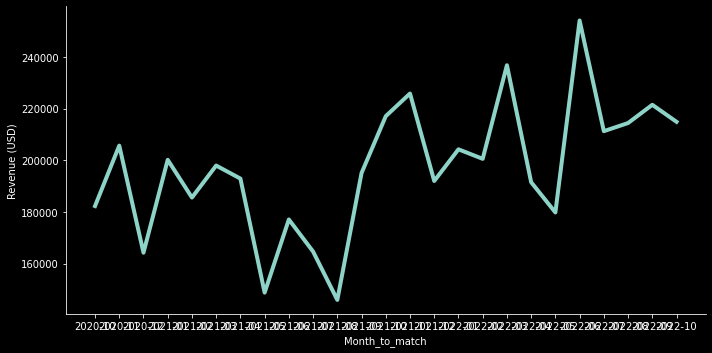

In [1558]:
sns.relplot(data = revenue_month , x = "Month_to_match", y = "Revenue (USD)", kind = "line",
                linewidth=4 , ci = None, height=5, aspect=10/5)
